**Quantum AI Project - Womanium 2024**

Team members:
* Apurva Dhingra
* Barnokhon Tashpulotova
* Kush Dhuvad


This project implements the protocol described in the paper **"Classically Verifiable Quantum Advantage from a Computational Bell Test"** by Meyer, Choi, Vazirani, and Yao [link](https://www.nature.com/articles/s41567-022-01643-7). The paper addresses a significant challenge in quantum computing: verifying the correctness of quantum computations using classical resources without incurring exponential costs.

The proposed protocol leverages trapdoor claw-free functions to create a classically verifiable quantum advantage. Unlike previous protocols, this approach circumvents the need for the adaptive hardcore bit, thereby simplifying the implementation without increasing quantum circuit complexity. The protocol also introduces innovations such as garbage bit discarding and a novel postselection method, which improve efficiency and reduce the fidelity requirements for demonstrating quantum advantage.

This notebook will guide you through the steps of implementing this protocol and exploring the underlying concepts.

In [ ]:
# installation and authentication -- Needed for google colab.
!pip install -U classiq

In [ ]:
import classiq
classiq.authenticate()

/usr/local/lib/python3.10/dist-packages/classiq/_internals/authentication/token_manager.py:99: UserWarning:

Device is already registered.
Generating a new refresh token should only be done if the current refresh token is compromised.
To do so, set the overwrite parameter to true



# Protocol overview and explanation

**Protocol Overview**

* The protocol involves three rounds of interaction between a quantum prover and a classical verifier.
* Each round consists of the verifier issuing a challenge and the prover responding. (as shown in the diagram below.)

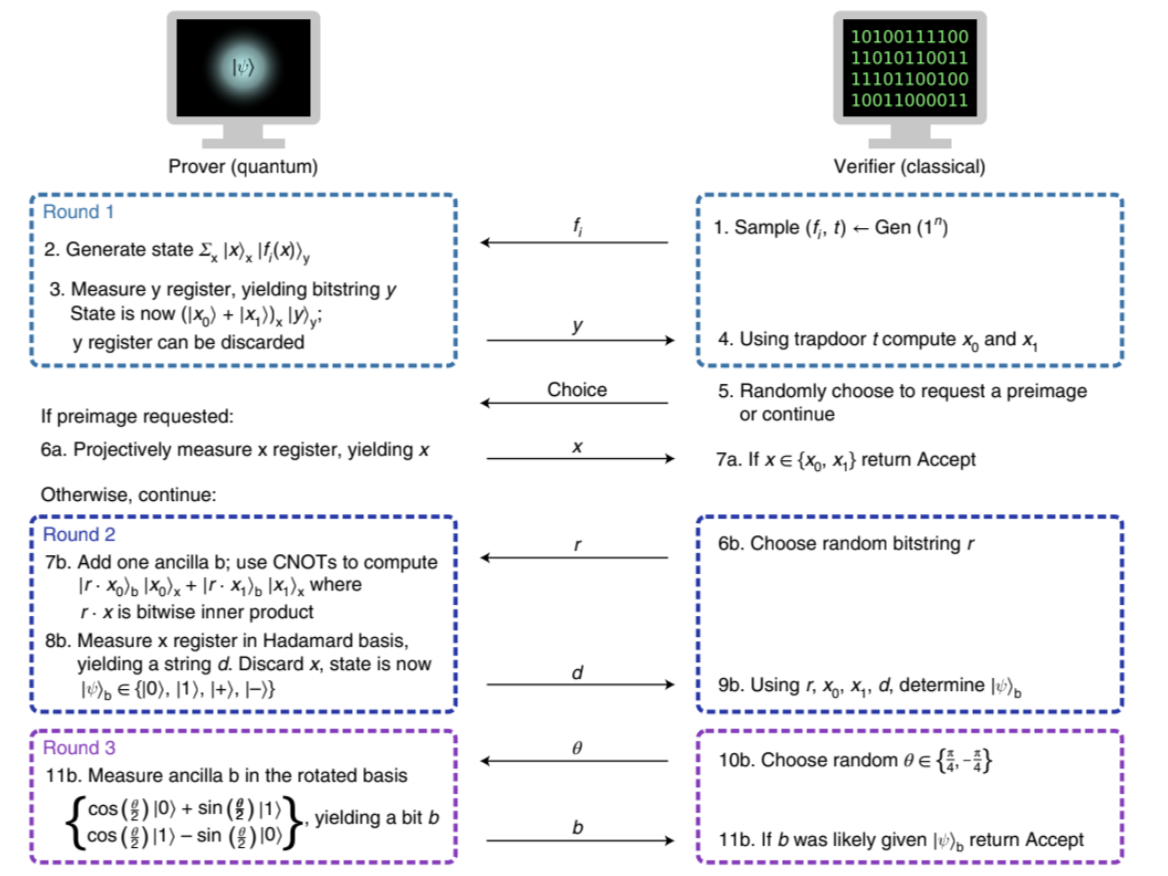

This is the diagram (* from the paper) that explains the protocol that is being implemented here.


**Round 1 :**

1.  The verifier selects an instance  $f_i$ of a trapdoor claw-free function (TCF) along with the associated trapdoor data $t$. We will be implementing $f_N(x) = x^2 mod N$, where $N = p*q$, i.e. N is a product of two prime factors, with the trapdoor data as tuple $(p,q)$.
2.  The prover initializes two registers of qubits $|x⟩, |y⟩$, then computes:
$ |ψ⟩ = ∑ |x⟩ ⊗|y⟩  = ∑ |x⟩ ⊗|x^2 mod N⟩$.
  * This is the core step in the quantum algorithm - they(authors of the paper) have used phase estimation technique to estimate the $|y⟩$ register.

 * Note: We have only implemented the simplest version of their quantum prover algorithm, and not the optimized version. Our main contribution (towards this project) is post-processing in such a way that this simple version can handle general values of N, i.e. $N != 2^n$.

3. The prover measures the $y$ register, collapsing the state to:
 $\left(|x_0⟩ + |x_1⟩ \right)_x |y⟩_y$ where $y = f(x_0) = f(x_1)$.

4. The bitstring y is sent to the verifier, who uses the trapdoor to compute $x_0$ ad $x_1$.

**In Between **
5. The verifier randomly decides whether to end the protocol or continue.

6. (a)If the verifier requests a projective measurement of the x register, the prover measures x and sends the result (either $x_0$ or $x_1$ to the verifier, who checks if $f(x) = y$.

7. (a) If the verifier received $x_0$ or $x_1$, the protocol ends.

Else:

**Round 2 :**

6. (b) The verifier sends a random bitstring r of the same length as x to the prover.

7. (b) The prover adds an ancilla qubit b and applies a series of CNOT gates to compute: $|r.x_0⟩_b |x_0⟩ + |r.x_1⟩_b |x_1⟩$ (with proper normalization), where $r.x$ is the binary inner product.

8. (b) The prover measures the x register in the Hadamard basis, obtaining a bitstring d, which is sent to the verifier.
 * The measurement disentangles x from b without collapsing the superposition of b. The state is now:
 $(-1)^{d.x_0}|r.x_0⟩  + (-1)^{d.x_1}|r.x_1⟩ $. This state is one of  $|𝛹⟩_b \in \{|0⟩, |1⟩ |+⟩, |-⟩\}$ and is cryptographically hard to predict.

9. (b) The verifier uses $r, x_0, x_1, d$ to determine $|𝛹⟩_b $.

**Round 3:**
10. (b) The verifier requests a measurement in a rotated basis, either by an angle $θ \in \{ π/4 , -π/4\}$ rotated from the Z axis around Y.

11. (b) Prover measures ancilla b in the rotated basis. The measurement outcome of b is then cryptographically protected and is correlated with the prover's state.

12. (b) The verifier **Accept** if the more likely outcome, given by $cos^2(\pi/8) ≈ 0.85$, is received.











# 1 : Main code

In [ ]:
from classiq import *
from classiq.qmod.symbolic import pi
import numpy as np

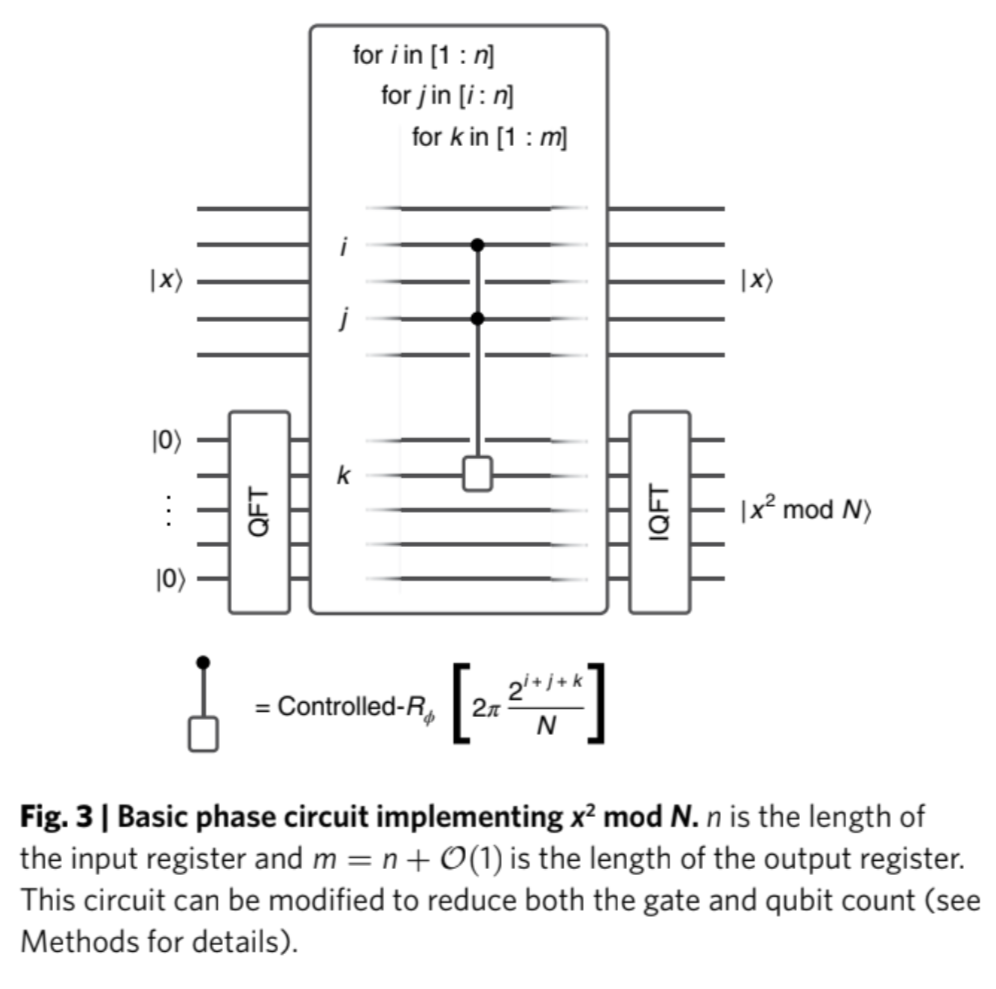

**~Quantum Phase Estimation**

The code block right below implements this above-shown circuit (Fig.3).

The *modular_sqaure* function takes the parameters $N,x,y$ and does the following steps.
1. Takes the hadamard of (y) or QFT of y. Note in this step, when QFT is taken it is with respect to $2^{y.size}$, where $y.size$ is the number of qbits in $|y⟩$ register.
2. Then for $i=j$ terms of the $|x⟩$ register, rotation is applied using the function *apply_rotations_1_ctrl*. In this case, control is the qbit $x[i]$.
  2.1 When $i !=j$, then there are two controls $x[i], x[j]$, so the rotaion of $y[k]$ is done using function *apply_rotations_2_ctrl*.

  2.2 Within the function *apply_rotations_1_ctrl*, note the phase has an extra factor of two; that is because there are pairs $(i,j), (j,i)$ for which the same phase is to be applied, and the is done in one go here.
3. The last step, after all the phase rotations, is applying inverse QFT.

In the paper, this has been shown in the following few steps :(screenshot below)



   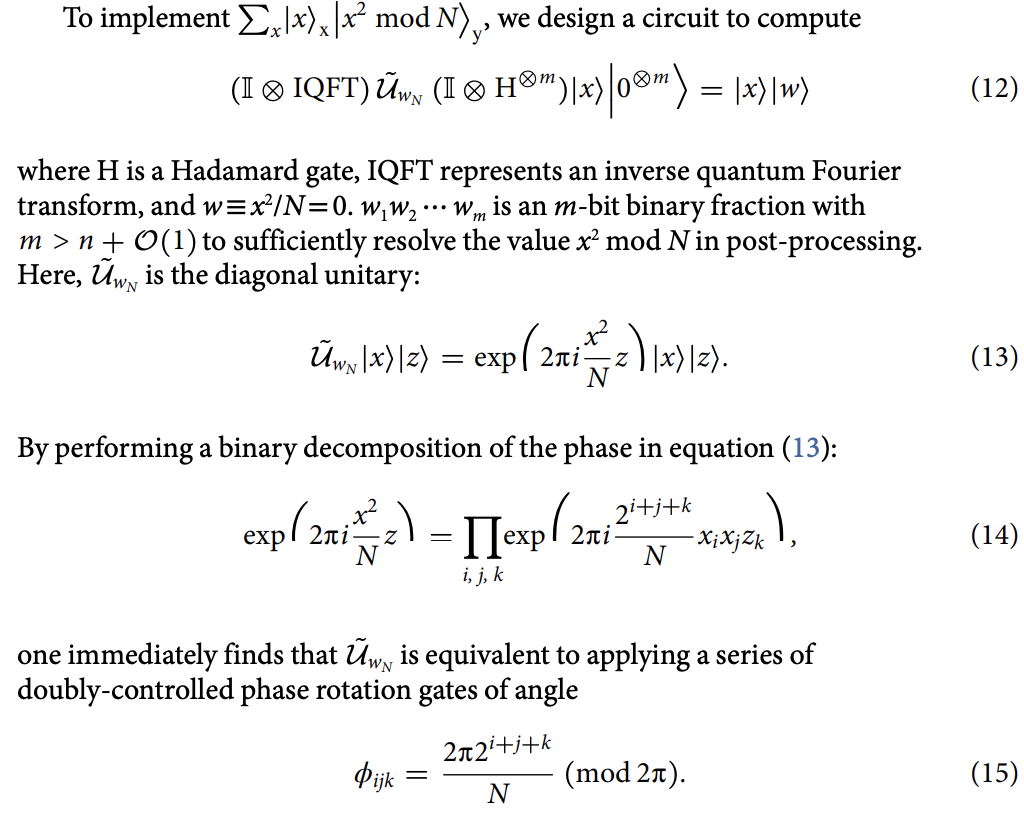

In [ ]:
## STEP 2 from above protocol.
@qfunc
def apply_rotations_2_ctrl(N: CInt, i: CInt, j: CInt, ctrl1: QBit, ctrl2: QBit,
                               y: QArray):
    ctrl = QArray("ctrl")
    bind([ctrl1, ctrl2], ctrl)
    control(ctrl,
      lambda: repeat(y.len,
      lambda k: PHASE(2 * 2 * pi*(2**(i+j+k)) / N, y[k])))
    bind(ctrl, [ctrl1, ctrl2])

@qfunc
def apply_rotations_1_ctrl(N: CInt, i: CInt, ctrl: QBit, y: QArray):
    control(ctrl,
        lambda: repeat(y.len,
        lambda k: PHASE(2 * pi*(2**(2*i+k)) / N, y[k])))

@qfunc
def modular_square(N: CInt, x: QArray, y: QArray):
      hadamard_transform(y)
      repeat(x.len,
        lambda i: apply_rotations_1_ctrl(N, i, x[i], y))

      repeat(x.len,
        lambda i: repeat(x.len - i - 1,
        lambda j: apply_rotations_2_ctrl(N, i, i + j + 1, x[i], x[i+j+1], y)))

      invert(lambda: qft(y))

In [ ]:
## STEP 6b.
# To generate a random bitstring
import random
import math

random.seed(42)

def generate_random_bitstring(length):
    return [random.randint(0, 1) for _ in range(length)]

# Length of the bitstring
bitstring_length = 4

# Generate random bitstring
random_bitstring = generate_random_bitstring(bitstring_length)
print("Random Bitstring:", random_bitstring)

#Generate a theta between {-pi/4 , pi/4}
theta=math.pi/4

Random Bitstring: [0, 0, 1, 0]


In [ ]:
## IN between whether STEP 5 OR directly 7b.

# To decide whether to run make a projective measurement on x-qbit or not.
import random

random.seed(44) # gets bit =1
#random.seed(42) # gets bit =0
def generate_random_bit():
    return random.randint(0, 1)

# Generate a random bit
bit = generate_random_bit()
# bit = 0 -- means we stop at round 1,
# bit = 1 -- means the process goes further.
print(bit)

1


In [ ]:
## STEP 7b, creating entagled bit with given bitstring r
@qfunc
def round2_entagle(i:CInt,r: CInt, x:QArray, auxiliary: QBit):
    control(ctrl=x[i], operand=lambda: X(auxiliary))

In [ ]:
## INITIALIZING , STEP 1 -- N is given.
N = 10                                 # N = 2*5 prime factorization
Y_SIZE = int(np.ceil(np.log2(N)))      # y_size = ceil(log_2(N))-- no of y-qbits
X_SIZE = int(np.ceil(np.log2(N)))      # X_size -- no of x-qbits
M = X_SIZE                             # M = decimal points in a value for QPE

@qfunc
def main(x: Output[QNum],y: Output[QNum],auxiliary: Output[QNum]):
    #x = QArray("x")
    allocate(X_SIZE, x)
    allocate_num(M,False,M, y)
    #inplace_prepare_int(3, x)
    allocate(1,auxiliary)
    hadamard_transform(x)
    modular_square(N, x, y)

    if bit == 0:
        print("Round 1 only")
    else:
        print("Round 2 and 3")
        for i, r_bit in enumerate(random_bitstring):
            if r_bit == 1:
              round2_entagle(i,random_bitstring, x, auxiliary)

        hadamard_transform(x)
        #theta=math.pi/4
        RY(theta,auxiliary)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

# Write the model to a file
write_qmod(qmod, "Main_code")


res = execute(qprog).result()
counts = res[0].value.parsed_counts
#counts

Round 2 and 3


<ipython-input-9-840df0fa3090>:4: DeprecationWarning: Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.
  control(ctrl=x[i], operand=lambda: X(auxiliary))


Opening: https://platform.classiq.io/circuit/c28a3d2a-fbf7-4043-aa38-1606e9cab082?version=0.44.0






# 1.1 : Only Round 1 executed and protcol ends.

If only round one is executed then, the following would have happened.

In [ ]:
N = 10                                  # N = 2*3 prime factorization
Y_SIZE = int(np.ceil(np.log2(N)))       # y_size = ceil(log_2(N))
X_SIZE = int(np.ceil(np.log2(N)))       # X_size is the domain of N
M = X_SIZE                              # M = decimal points in a value

@qfunc
def main(x: Output[QNum],y: Output[QNum],auxiliary: Output[QNum]):
    #x = QArray("x")
    allocate(X_SIZE, x)
    allocate_num(M,False,M, y)
    #inplace_prepare_int(3, x)
    allocate(1,auxiliary)
    hadamard_transform(x)
    modular_square(N, x, y)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)
write_qmod(qmod, "Only_Round_1_code")
res = execute(qprog).result()
counts = res[0].value.parsed_counts
#counts

Opening: https://platform.classiq.io/circuit/b019810c-826e-4a7c-bf2c-e93516875fee?version=0.44.0


In [ ]:
# Post-processing
## Checking y is correct or not, and getting to see x_0 and x_1 for any given y.
def closest_fraction(x, denominator):
    return round(x * denominator)
x_list = []
y_list = []
y_true = []
for count in counts:
    if count.shots > 2048/N*0.10:
        x = count.state['x']
        y = closest_fraction(count.state['y'], N)
        print("x:", x, "x^2%N:", x ** 2 % N, "measured:", y, "shots:", count.shots, 'prob:',count.shots/2048, "auxiliary :",count.state['auxiliary'])
        x_list.append(x)
        y_list.append(y)
        y_true.append(x ** 2 % N)

x: 15.0 x^2%N: 5.0 measured: 5 shots: 149 prob: 0.07275390625 auxiliary : 0.0
x: 10.0 x^2%N: 0.0 measured: 0 shots: 135 prob: 0.06591796875 auxiliary : 0.0
x: 0.0 x^2%N: 0.0 measured: 0 shots: 132 prob: 0.064453125 auxiliary : 0.0
x: 5.0 x^2%N: 5.0 measured: 5 shots: 127 prob: 0.06201171875 auxiliary : 0.0
x: 11.0 x^2%N: 1.0 measured: 1 shots: 80 prob: 0.0390625 auxiliary : 0.0
x: 12.0 x^2%N: 4.0 measured: 4 shots: 77 prob: 0.03759765625 auxiliary : 0.0
x: 4.0 x^2%N: 6.0 measured: 6 shots: 75 prob: 0.03662109375 auxiliary : 0.0
x: 1.0 x^2%N: 1.0 measured: 1 shots: 74 prob: 0.0361328125 auxiliary : 0.0
x: 3.0 x^2%N: 9.0 measured: 9 shots: 72 prob: 0.03515625 auxiliary : 0.0
x: 2.0 x^2%N: 4.0 measured: 4 shots: 71 prob: 0.03466796875 auxiliary : 0.0
x: 14.0 x^2%N: 6.0 measured: 6 shots: 65 prob: 0.03173828125 auxiliary : 0.0
x: 6.0 x^2%N: 6.0 measured: 6 shots: 64 prob: 0.03125 auxiliary : 0.0
x: 9.0 x^2%N: 1.0 measured: 1 shots: 64 prob: 0.03125 auxiliary : 0.0
x: 7.0 x^2%N: 9.0 measure

Now, notice, if the y register is measured and say y=9 is considered. Then x = 3,7,13 all give x^2mod10 = 9.
This can be seen in the diagram below:

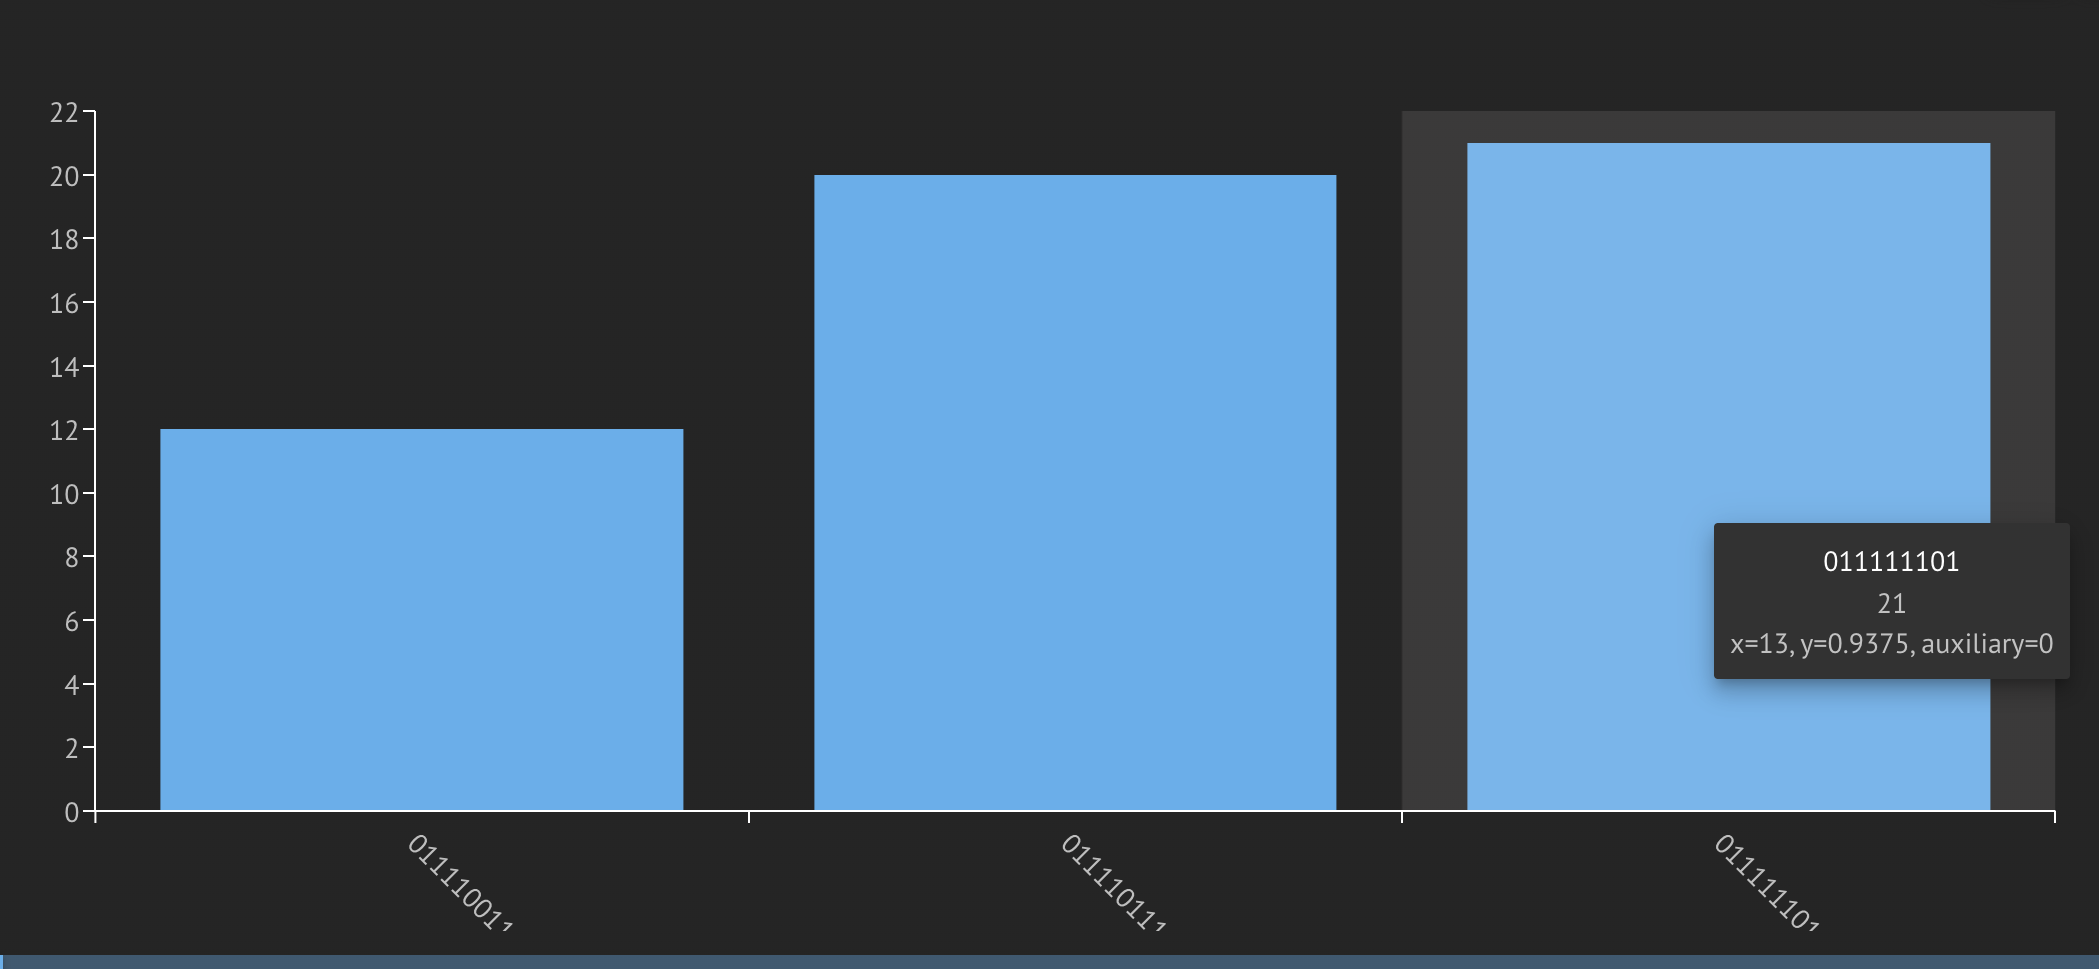

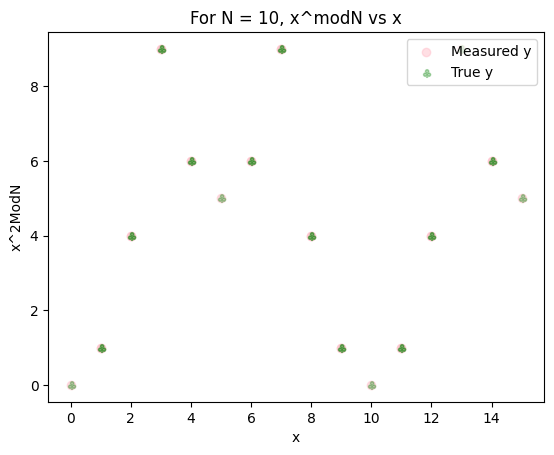

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

plt.scatter(x_list, y_list, c="pink", alpha=0.5, label = "Measured y")
plt.scatter(x_list, y_true, c= 'g' , alpha=0.3,marker=r'$\clubsuit$', label = "True y")
plt.xlabel("x")
plt.ylabel("x^2ModN")
plt.legend(loc='upper right')
plt.title("For N = 10, x^modN vs x")
plt.show()


* From this above plot, we can see that, for $N =10$, the $ y = x^2 mod N$ values match the true values for most as shown.
* If $N =15$ is taken, that's not the case. (Here 5 of the measured values differ from the true $x^2mod15$ values). Consider the below image.



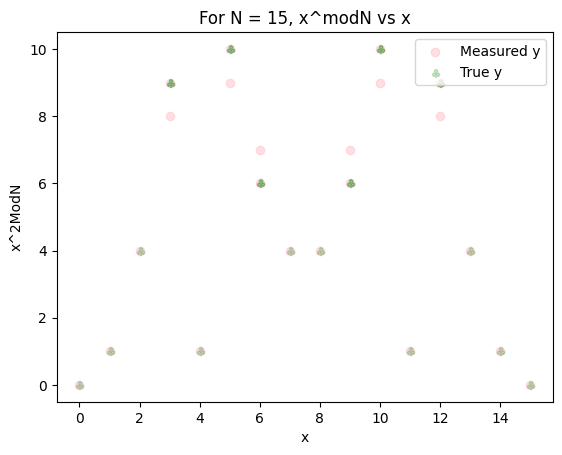



#  1.2 :  Round 1,2,3 all are executed

If, on the other hand, rounds 2 and 3 are also executed, then x is measured on a Hadamard basis; this leaves behind an auxiliary string.

In [ ]:
N = 10                                   # N = 2*3 prime factorization
Y_SIZE = int(np.ceil(np.log2(N)))       # y_size = ceil(log_2(N))
X_SIZE = int(np.ceil(np.log2(N)))       # X_size is the domain of N
M = X_SIZE                              # M = decimal points in a value

@qfunc
def main(x: Output[QNum],y: Output[QNum],auxiliary: Output[QNum]):
    #x = QArray("x")
    allocate(X_SIZE, x)
    allocate_num(M,False,M, y)
    #inplace_prepare_int(3, x)
    allocate(1,auxiliary)
    hadamard_transform(x)
    modular_square(N, x, y)

    if bit == 0:
        print("Round 1 only")
    else:
        print("Round 2 and 3")
        for i, r_bit in enumerate(random_bitstring):
            if r_bit == 1:
              round2_entagle(i,random_bitstring, x, auxiliary)

        hadamard_transform(x)
        #theta=math.pi/4
        RY(theta,auxiliary)

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

write_qmod(qmod, "All rounds_code")
res = execute(qprog).result()
counts = res[0].value.parsed_counts

Round 2 and 3


<ipython-input-9-840df0fa3090>:4: DeprecationWarning: Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.
  control(ctrl=x[i], operand=lambda: X(auxiliary))


Opening: https://platform.classiq.io/circuit/de0e21eb-cedc-4538-86f2-ecb4145aa016?version=0.44.0


In [ ]:
# Post-processing
def closest_fraction(x, denominator):
    return round(x * denominator)

for count in counts:
    if count.shots > 2048/N*0.10:
        x = count.state['x']
        y = closest_fraction(count.state['y'], N)

        print("Hadamard(x):", x, "x^2%N:", x ** 2 % N, "measured:", y, "shots:", count.shots, 'prob:',count.shots/2048, "auxiliary :",count.state['auxiliary'])
        x_list.append(x)
        y_list.append(y)
        y_true.append(x ** 2 % N)

x: 5.0 x^2%N: 5.0 measured: 1 shots: 52 prob: 0.025390625 auxiliary : 0.0
x: 0.0 x^2%N: 0.0 measured: 1 shots: 51 prob: 0.02490234375 auxiliary : 0.0
x: 1.0 x^2%N: 1.0 measured: 6 shots: 42 prob: 0.0205078125 auxiliary : 1.0
x: 4.0 x^2%N: 6.0 measured: 1 shots: 39 prob: 0.01904296875 auxiliary : 0.0
x: 1.0 x^2%N: 1.0 measured: 5 shots: 37 prob: 0.01806640625 auxiliary : 1.0
x: 0.0 x^2%N: 0.0 measured: 6 shots: 37 prob: 0.01806640625 auxiliary : 1.0
x: 5.0 x^2%N: 5.0 measured: 0 shots: 36 prob: 0.017578125 auxiliary : 0.0
x: 0.0 x^2%N: 0.0 measured: 9 shots: 36 prob: 0.017578125 auxiliary : 1.0
x: 1.0 x^2%N: 1.0 measured: 0 shots: 36 prob: 0.017578125 auxiliary : 0.0
x: 0.0 x^2%N: 0.0 measured: 5 shots: 35 prob: 0.01708984375 auxiliary : 1.0
x: 5.0 x^2%N: 5.0 measured: 6 shots: 35 prob: 0.01708984375 auxiliary : 1.0
x: 4.0 x^2%N: 6.0 measured: 5 shots: 34 prob: 0.0166015625 auxiliary : 1.0
x: 5.0 x^2%N: 5.0 measured: 5 shots: 33 prob: 0.01611328125 auxiliary : 1.0
x: 10.0 x^2%N: 0.0 mea

In [ ]:
"""
Here is the example that  that after the  measuerment of the x register in round 2 if we recieve the bitstring d as 0100
and we had the randam bitstring r as 0011 at the 6b step of round 2 then with the the values of x1 and x2 we can determine the state of
ancilla qubit using the following classical computation
"""
import numpy as np

def to_binary(num, length):
    """Convert a number to a binary string of a given length."""
    return bin(num)[2:].zfill(length)

def dot_product(bin_str1, bin_str2):
    """Compute the dot product of two binary strings."""
    return sum(int(b1) * int(b2) for b1, b2 in zip(bin_str1, bin_str2)) % 2

# Convert numbers to binary strings of equal length
length = max(len(bin(7)[2:]), len(bin(8)[2:]), len(bin(4)[2:]), len(bin(3)[2:]))

x0 = to_binary(1, length)
x1 = to_binary(11, length)
d = to_binary(4, length)
r = to_binary(3, length)

# Compute the dot products
dx0 = dot_product(d, x0)
dx1 = dot_product(d, x1)
rx0 = dot_product(r, x0)
rx1 = dot_product(r, x1)

# Calculate the quantum state expression
state = ((-1) ** dx0) * rx0 + ((-1) ** dx1) * rx1

# Determine the final state
if state == 0:
    result = "|0⟩"
elif state == 1:
    result = "|1⟩"
elif state == 2:
    result = "|+⟩"
else:
    result = "|−⟩"

# Output the result
print(f"x0: {x0}, x1: {x1}, d: {d}, r: {r}")
print(f"(−1)^(d·x0)|r · x0⟩_b + (−1)^(d·x1)|r · x1⟩_b = {result}")
print("ancilla qubit is in state",result)

x0: 0001, x1: 1011, d: 0100, r: 0011
(−1)^(d·x0)|r · x0⟩_b + (−1)^(d·x1)|r · x1⟩_b = |1⟩
ancilla qubit is in state |1⟩


RESOURCE ESTIMATION

In [ ]:
providers = ["Classiq", "Azure Quantum" , "IBM Quantum", ]
analyzer = Analyzer(circuit = QuantumProgram.from_qprog(qprog))
analyzer.get_hardware_comparison_table(providers = providers)
analyzer.plot_hardware_comparison_table()

OPTIMIZING THE DEPTH OF THE QUANTUM CIRCUIT FOR THE MOST ADEQUATE HARDWARE

In [ ]:
from classiq.execution import AzureBackendPreferences, ExecutionPreferences
from classiq.synthesis import set_execution_preferences
preferences = Preferences(backend_service_provider = "Azure Quantum", backend_name = "ionq")
contraints = Constraints(optimization_parameter="depth", max_width = 50)
model = create_model(main, contraints, preferences)
q = synthesize(model)
circuit = QuantumProgram.from_qprog(q)
print("Width = ", circuit.data.width)
print("Depth = ", circuit.transpiled_circuit.depth)
print(circuit.transpiled_circuit.get_circuit_metrics())

Round 2 and 3


<ipython-input-9-840df0fa3090>:4: DeprecationWarning:

Parameter 'operand' of function 'control' has been renamed to 'stmt_block'. Parameter 'operand' will be deprecated in a future release.
Hint: Change `control(ctrl=..., operand=...)` to `control(ctrl=..., stmt_block=...)` or `control(..., ...)`.



Width =  9
Depth =  255
depth=255 count_ops={'u': 245, 'cx': 243}
